# Semester Project: Exploring large language model performance in college-level project evaluation as a means to improving course quality

Skyler Brough and Trina Brough  
CS 533  
Fall 2025  

## Set up

### Installs (for Google Colab)

In [ ]:
!pip install --upgrade --no-cache-dir torch torchvision torchaudio transformers accelerate safetensors bitsandbytes huggingface_hub sheetwise openai


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 215.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 176.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 116.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 243.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 413.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 213.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 387.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 269.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 217.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Imports

In [1]:
import torch
torch.cuda.get_device_name(0)


'NVIDIA A100-SXM4-80GB'

In [ ]:
HUGGING_FACE_KEY = ''
OPEN_AI_KEY = ""

In [2]:

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import os
from huggingface_hub import login

login(HUGGING_FACE_KEY) #for hugging face
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from openai import OpenAI
import re
import torch
import gc
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    mean_squared_error,
    mean_absolute_error,
    confusion_matrix,
    classification_report
)
import seaborn as sns



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Variable Specs

In [4]:
AGG_FUNCTIONS = {"SUM", "AVERAGE", "COUNT", "MAX", "MIN", "MEDIAN", "MODE"}

data_folder = "/content/drive/My Drive/CS533 Semester Project/CapstoneProjectsData"
ground_truth = "CapstoneProjectDataReferenceTable.xlsx"


### Cleaning functions

In [6]:
def extract_first_json(text):
    brace_count = 0
    start_idx = None
    for i, char in enumerate(text):
        if char == '{':
            if brace_count == 0:
                start_idx = i
            brace_count += 1
        elif char == '}':
            brace_count -= 1
            if brace_count == 0 and start_idx is not None:
                return text[start_idx:i+1]
    return None

def clean_json_string(json_str):
    # Remove trailing commas before } or ]
    json_str = re.sub(r',(\s*[}\]])', r'\1', json_str)
    # Replace any smart quotes with regular quotes
    json_str = json_str.replace('“', '"').replace('”', '"').replace("‘", "'").replace("’", "'")
    return json_str

## Data

### Ground Truth Scores

In [7]:
scores = pd.read_excel(data_folder+'/'+ground_truth)
scores.head()

,FileName,Semester,Score,Data,Aggregate,Graph,Advanced,Paragraph,Reason,Explanation
0,andersonkael,S25013,5,1,1,1,1,1,NaN,NaN
1,bargerjessica,S25013,5,1,1,1,1,1,NaN,NaN
2,beerytristen,S25013,4,1,1,1,1,0,Paragraph,Missing Paragraph
3,belljessica,S25013,5,1,1,1,1,1,NaN,NaN
4,bredesonjack,S25013,5,1,1,1,1,1,NaN,NaN


### Attempt 1: Extract spreadsheet data as JSON

In [ ]:
from openpyxl import load_workbook
import json
import re

def extract_functions(formula):
    """Extracts function names from Excel formula."""
    if not formula or not isinstance(formula, str):
        return []
    return re.findall(r"\b[A-Z]+\b", formula)


In [ ]:


CELL_REF_PATTERN = re.compile(r"([A-Z]+[0-9]+|\'[^\']+\'![A-Z]+[0-9]+)")

def extract_spreadsheet_metadata(file_path):
    """
    Extracts values, formulas, formatting, and explicit cell references from Excel.
    Returns a JSON string.
    """
    wb = load_workbook(file_path, data_only=False)
    all_sheets = {}

    for sheetname in wb.sheetnames:
        ws = wb[sheetname]
        sheet_info = {
            "sheet_name": sheetname,
            "max_row": ws.max_row,
            "max_column": ws.max_column,
            "has_charts": bool(ws._charts),
            "chart_count": len(ws._charts),
            "cells": {}
        }

        for row in ws.iter_rows():
            for cell in row:
                coord = cell.coordinate
                formula = cell.value if cell.data_type == "f" else None
                functions = extract_functions(formula)
                aggregations = [f for f in functions if f.upper() in AGG_FUNCTIONS]

                # Extract all referenced cells in the formula
                references = []
                if formula:
                    references = CELL_REF_PATTERN.findall(formula)

                # Safely convert color objects to strings
                font_color = None
                if cell.font.color:
                    font_color = (
                        cell.font.color.rgb
                        if cell.font.color.type == "rgb"
                        else str(cell.font.color)
                    )

                fill_color = None
                if cell.fill.fgColor:
                    fill_color = (
                        cell.fill.fgColor.rgb
                        if cell.fill.fgColor.type == "rgb"
                        else str(cell.fill.fgColor)
                    )

                cell_info = {
                    "value": cell.value,
                    "formula": formula,
                    "functions": functions,
                    "aggregations": aggregations if aggregations else None,
                    "references": references if references else None,
                    "number_format": cell.number_format,
                    "font": {
                        "bold": cell.font.bold,
                        "italic": cell.font.italic,
                        "color": font_color,
                    },
                    "fill": {
                        "fgColor": fill_color,
                    },
                    "alignment": {
                        "horizontal": cell.alignment.horizontal,
                        "vertical": cell.alignment.vertical,
                    },
                    "comment": cell.comment.text if cell.comment else None,
                }

                sheet_info["cells"][coord] = cell_info

        all_sheets[sheetname] = sheet_info

    return json.dumps(all_sheets, indent=2)


In [ ]:
#Saving individual elements without the entire metadata
from openpyxl import load_workbook

def load_workbook_all_sheets(path):
    """Loads the workbook and returns a dictionary of all sheets. Keys are sheet names, values are worksheet objects."""
    wb = load_workbook(path, data_only=True)
    sheets = {sheet.title: sheet for sheet in wb.worksheets}
    return sheets

def extract_data(sheet):
    """
    Extracts all rows from a worksheet as a list of lists. Skips rows that are completely empty."""
    rows = []

    # Iterate through all rows in the worksheet
    for row in sheet.iter_rows(values_only=True):
        row_values = []
        for cell in row:
            row_values.append(cell)
        # Check if the row has at least one non-empty cell
        has_data = False
        for value in row_values:
            if value is not None:
                has_data = True
                break
        # Only append rows that have data
        if has_data:
            rows.append(row_values)
    return rows


#Step 1: Load all sheets
sheets = load_workbook_all_sheets('./widrigellie.xlsx')

#Step 2: Loop through each sheet
for sheet_name, sheet in sheets.items():
    print(f"\n Sheet: {sheet_name}")

    #Step 3: Extract all rows
    all_rows = extract_data(sheet)

    #Step 4: Print a sample (first 5 rows) to test
    for row in all_rows[:5]:
        print(row)

    #Print total number of rows
    print(f"Total rows in sheet: {len(all_rows)}")




 Sheet: StarbucksDrinks
['Beverage_category', 'Beverage', 'Beverage_prep', 'Calories', ' Total Fat (g)', 'Trans Fat (g) ', 'Saturated Fat (g)', ' Sodium (mg)', ' Total Carbohydrates (g) ', 'Cholesterol (mg)', ' Dietary Fibre (g)', ' Sugars (g)', ' Protein (g) ', 'Vitamin A (% DV) ', 'Vitamin C (% DV)', ' Calcium (% DV) ', 'Iron (% DV) ', 'Caffeine (mg)']
['Coffee', 'Brewed Coffee', 'Short', 3, 0.1, 0, 0, 0, 5, 0, 0, 0, 0.3, 0, 0, 0, 0, 175]
['Coffee', 'Brewed Coffee', 'Tall', 4, 0.1, 0, 0, 0, 10, 0, 0, 0, 0.5, 0, 0, 0, 0, 260]
['Coffee', 'Brewed Coffee', 'Grande', 5, 0.1, 0, 0, 0, 10, 0, 0, 0, 1, 0, 0, 0, 0, 330]
['Coffee', 'Brewed Coffee', 'Venti', 5, 0.1, 0, 0, 0, 10, 0, 0, 0, 1, 0, 0, 0.02, 0, 410]
Total rows in sheet: 246

 Sheet: SaturatedFatsPivotTable
['Row Labels', 'Sum of Saturated Fat (g)']
['Classic Espresso Drinks', 2.7]
['CaffÃ¨ Americano', 0]
['CaffÃ¨ Latte', 0.8]
['CaffÃ¨ Mocha (Without Whipped Cream)', 0.6000000000000001]
Total rows in sheet: 47

 Sheet: ProteinbyMilk


In [ ]:
def save_metadata_to_json(input_xlsx, output_json):
    metadata_json = extract_spreadsheet_metadata(input_xlsx)
    with open(output_json, "w", encoding="utf-8") as f:
        f.write(metadata_json)
    print(f"Metadata saved to {output_json}")



# if __name__ == "__main__":
#     # Example usage
#     input_file = "student_project.xlsx"    # path to spreadsheet
#     output_file = "student_project_metadata.json"
#     save_metadata_to_json(input_file, output_file)

In [ ]:
test_1 = extract_spreadsheet_metadata('./widrigellie.xlsx')

In [ ]:
len(test_1)

2731089

In [ ]:
test_1_json= json.loads(test_1)

In [ ]:
test_1_json['StarbucksDrinks']['cells']['P18']

{'value': 0.15,
 'formula': None,
 'functions': [],
 'aggregations': None,
 'references': None,
 'number_format': '0%',
 'font': {'bold': False,
  'italic': False,
  'color': "<openpyxl.styles.colors.Color object>\nParameters:\nrgb=None, indexed=None, auto=None, theme=1, tint=0.0, type='theme'"},
 'fill': {'fgColor': '00000000'},
 'alignment': {'horizontal': None, 'vertical': None},
 'comment': None}

### Attempt 2: Extract spreadsheet data using SheetLLM compression method (https://arxiv.org/abs/2407.09025)

In [ ]:
from sheetwise import SpreadsheetLLM


df = pd.read_excel('./widrigellie.xlsx')
llm_ready_text = SpreadsheetLLM().compress_and_encode_for_llm(df)




### Attempt 3: Curated data gathering

In [ ]:
def excel_has_pivot_table(path):
    """
    Detects whether an .xlsx workbook contains any pivot tables.
    """
    with zipfile.ZipFile(path, "r") as z:
        names = z.namelist()

        # pivot cache definitions
        has_cache = any(name.startswith("xl/pivotCache/") for name in names)

        # actual pivot table definitions
        has_pivot = any(name.startswith("xl/pivotTables/") for name in names)

        return has_cache or has_pivot

In [ ]:
#excel_has_pivot_table('./widrigellie.xlsx')
excel_has_pivot_table('./millerryan.xlsx')

False

In [ ]:
from openpyxl import load_workbook
import re
import zipfile

def extract_spreadsheet_features(path):
    wb = load_workbook(path, data_only=False)

    # Patterns
    agg_pattern = re.compile(r"(SUM|AVERAGE|COUNT|MAX|MIN)\(", re.IGNORECASE)
    adv_pattern = re.compile(
        r"(VLOOKUP|HLOOKUP|COUNTIFS|MATCH|INDEX|IF)",
        re.IGNORECASE,
    )

    # Extraction containers
    sheet_row_counts = {}      # sheet_name -> number of valid data rows
    agg_functions = set()
    advanced_functions = set()
    has_chart = False
    paragraph_cells = []

    # -----------------------------
    #   SINGLE PASS THROUGH SHEETS
    # -----------------------------
    for sheet in wb.worksheets:

        # Track data rows for this sheet
        data_rows = 0

        # Check charts for this sheet
        if len(sheet._charts) > 0:
            has_chart = True

        for row in sheet.iter_rows():
            row_values = [cell.value for cell in row]

            # ---------- Check data rows ----------
            nonempty = any(v not in [None, ""] for v in row_values)
            contains_numeric = any(isinstance(v, (int, float)) for v in row_values)

            if nonempty and contains_numeric:
                data_rows += 1

            # ---------- Check formulas ----------
            for cell in row:
              if cell.value is not None:
                cell_value = str(cell.value)

                # Check aggregation
                m = agg_pattern.search(cell_value)
                if m:
                    agg_functions.add(m.group(1).upper())

                # Check advanced functions (including PIVOT)
                m = adv_pattern.search(cell_value)
                if m:
                    fn = m.group(1).upper()


                # ---------- Check for explanatory paragraph ----------
                if isinstance(cell.value, str):
                    words = cell.value.split()
                    if len(words) >= 20:
                        paragraph_cells.append(cell.value)

        # store this sheet's data row count
        sheet_row_counts[sheet.title] = data_rows

    # Pick the sheet with most data rows
    best_sheet = max(sheet_row_counts, key=sheet_row_counts.get)
    data_points = sheet_row_counts[best_sheet]

    #check for pivot table
    if excel_has_pivot_table(path):
      advanced_functions.add("PIVOT_TABLE")

    # Result object for LLM
    result = {
        "data_points_count": data_points,
        "sheet_used_for_count": best_sheet,
        "aggregation": {
            "exists": len(agg_functions) > 0,
            "functions_found": list(agg_functions)
        },
        "graph": {
            "exists": has_chart
        },
        "advanced_function": {
            "exists": len(advanced_functions) > 0,
            "functions_found": list(advanced_functions)
        },
        "explanatory_paragraph": {
            "exists": len(paragraph_cells) > 0,
            "text": paragraph_cells[0] if paragraph_cells else ""
        }
    }

    return result



In [ ]:
test = extract_spreadsheet_features('./widrigellie.xlsx')

In [ ]:
test

{'data_points_count': 242,
 'sheet_used_for_count': 'StarbucksDrinks',
 'aggregation': {'exists': True, 'functions_found': ['SUM', 'MAX']},
 'graph': {'exists': True},
 'advanced_function': {'exists': True, 'functions_found': ['PIVOT_TABLE']},
 'explanatory_paragraph': {'exists': True,
  'text': "For my Capstone Project, I chose to focus on the nutrition facts of various Starbucks drinks. As a fan of Starbucks, I thought it would be both a fun and interesting topic to explore. Analyzing the nutritional content of different beverages was an easy way for me to incorporate numbers into my spreadsheet, and use various functions such as SUM and MAX. It also allowed me to use the PivotTable feature which is something I've struggled on in previous assignments."}}

In [ ]:
test['explanatory_paragraph']['text']

"For my Capstone Project, I chose to focus on the nutrition facts of various Starbucks drinks. As a fan of Starbucks, I thought it would be both a fun and interesting topic to explore. Analyzing the nutritional content of different beverages was an easy way for me to incorporate numbers into my spreadsheet, and use various functions such as SUM and MAX. It also allowed me to use the PivotTable feature which is something I've struggled on in previous assignments."

## Prompt Bank

In [ ]:
RUBRIC = [
    '30 unique data points',
    'aggregation',
    'graph',
    'advanced formula',
    'explanatory paragraph'
]

rubric_text = "\n- " + "\n- ".join(RUBRIC)



### Prompt 1: Simple structured grading

In [ ]:
def prompt1(features):
  persona = 'You are a detailed spreadsheet grader.'

  prompt1 = f"""
  Respond ONLY with a single JSON object.
  Do NOT add text, comments, or repeat the JSON.

  Task:
    - Review the JSON representing a student spreadsheet.
    - Assign 1 for each rubric item that is met, 0 if not.
    - Provide short comment for each.
    - Sum total_score.

  Return JSON:
  {{
    "At least 30 unique data points": {{"score": X, "comment": "..."}},
    "aggregation": {{"score": X, "comment": "..."}},
    "graph": {{"score": X, "comment": "..."}},
    "advanced function": {{"score": X, "comment": "..."}},
    "explanatory paragraph": {{"score": X, "comment": "..."}},
    "total_score": XX
  }}

  RUBRIC:{rubric_text}
  JSON:
  {features}
  END
  """

  return persona + prompt1



### Additional Prompts

In [ ]:
# Minimal output

prompt2 = '''
    Task:
        - Assign 0 or 1 for each rubric item.
        - Include total_score only, no comments.

        Return JSON:
        {
          "30 unique data points": X,
          "aggregation": X,
          "graph": X,
          "something that scares you": X,
          "explanatory paragraph": X,
          "total_score": XX
        }

        RUBRIC:

        JSON:
        {paste JSON here}

'''

In [ ]:
#Yes/No style
prompt3 = '''
    Task:
        - For each rubric item, write "Yes" if met, "No" if not.
        - Include optional short comment.

    Return JSON:
        {
          "30 unique data points": {"met": "Yes", "comment": "..."},
          "aggregation": {"met": "No", "comment": "..."},
          "graph": {"met": "Yes", "comment": "..."},
          "something that scares you": {"met": "Yes", "comment": "..."},
          "explanatory paragraph": {"met": "No", "comment": "..."},
          "total_score": XX
        }

    RUBRIC:

    JSON:
        {paste JSON here}

'''

In [ ]:
# Full reasoning per criterion
prompt4 = '''
    Task:
        - Explain 1–2 sentences per rubric criterion.
        - Assign 1 if met, 0 if not.
        - Sum total_score.

    Return JSON:
        {
          "30 unique data points": {"score": X, "explanation": "..."},
          "aggregation": {"score": X, "explanation": "..."},
          "graph": {"score": X, "explanation": "..."},
          "something that scares you": {"score": X, "explanation": "..."},
          "explanatory paragraph": {"score": X, "explanation": "..."},
          "total_score": XX
        }

    RUBRIC:

    JSON:
        {paste JSON here}

'''

In [ ]:
# Checklist with suggestions
prompt5 = '''
   Task:
        - For each rubric item, assign 0 or 1.
        - Include one improvement suggestion if 0.

        Return JSON:
        {
          "30 unique data points": {"score": X, "suggestion": "..."},
          "aggregation": {"score": X, "suggestion": "..."},
          "graph": {"score": X, "suggestion": "..."},
          "something that scares you": {"score": X, "suggestion": "..."},
          "explanatory paragraph": {"score": X, "suggestion": "..."},
          "total_score": XX
        }

    RUBRIC:

    JSON:
        {paste JSON here}


'''

In [ ]:
# Focus on aggregations
prompt6 = '''
   Task:
    - Check for aggregation formulas: SUM, AVERAGE, COUNT, MAX, MIN, MEDIAN.
    - Score "aggregation" rubric item 1 if present, 0 if not.
    - Comment on formula usage.

    Return JSON:
    {
      "aggregation": {"score": X, "comment": "..."}
    }

    JSON:
    {paste JSON here}


'''

In [ ]:
# Focus on scary functions
prompt7 = '''
  Task:
    - Check for IF, XLOOKUP, VLOOKUP, INDEX/MATCH, Pivot Table, Conditional Formatting.
    - Score "something that scares you" 1 if any present, 0 if not.
    - Comment on which feature was used.

    Return JSON:
    {
      "something that scares you": {"score": X, "comment": "..."}
    }

    JSON:
    {paste JSON here}


'''

In [ ]:
# Focus on graph/chart detection
prompt8 = '''
  Task:
    - Detect any chart in the workbook.
    - Score "graph" rubric item 1 if present, 0 if not.
    - Comment on type of chart.

    Return JSON:
    {
      "graph": {"score": X, "comment": "..."}
    }

    JSON:
    {paste JSON here}
'''

In [ ]:
# Data points detection
prompt9 = '''
  Task:
    - Check if spreadsheet has at least 30 unique data points.
    - Score rubric item accordingly.
    - Comment on total unique entries.

    Return JSON:
    {
      "30 unique data points": {"score": X, "comment": "..."}
    }

    JSON:
    {paste JSON here}
'''

In [ ]:
# Explanatory paragraph detection
prompt10 = '''
  Task:
    - Detect text in a designated cell or comment for explanatory paragraph.
    - Score 1 if present, 0 if not.
    - Comment on location/length.

    Return JSON:
    {
      "explanatory paragraph": {"score": X, "comment": "..."}
    }

    JSON:
    {paste JSON here}
'''

In [ ]:
# Aggregate grading
prompt11 = '''
  Task:
    - Check all rubric items in one pass.
    - Assign 1/0 per item.
    - Include total_score.
    - Include brief comment per item.

    Return JSON:
    {
      "30 unique data points": {"score": X, "comment": "..."},
      "aggregation": {"score": X, "comment": "..."},
      "graph": {"score": X, "comment": "..."},
      "something that scares you": {"score": X, "comment": "..."},
      "explanatory paragraph": {"score": X, "comment": "..."},
      "total_score": XX
    }

    RUBRIC:

    JSON:
    {paste JSON here}
'''

In [ ]:
#  Minimal total + comment
prompt12 = '''
  Task:
    - Only return total_score.
    - Optionally include one-line summary comment.

    Return JSON:
    {
      "total_score": XX,
      "comment": "Student included aggregation and chart but no paragraph."
    }

    RUBRIC:

    JSON:
    {paste JSON here}
'''

In [ ]:
# Step-by-step reasoning
prompt13 = '''
  Task:
    - For each rubric item, explain reasoning step-by-step:
      1. What was found in JSON.
      2. Whether it meets rubric criterion.
      3. Assign score 1 or 0.
    - Sum total_score.

    Return JSON:
    {
      "30 unique data points": {"score": X, "explanation": "..."},
      "aggregation": {"score": X, "explanation": "..."},
      "graph": {"score": X, "explanation": "..."},
      "something that scares you": {"score": X, "explanation": "..."},
      "explanatory paragraph": {"score": X, "explanation": "..."},
      "total_score": XX
    }

    JSON:
    {paste JSON here}
'''

In [ ]:
# Short human-readable feedback
prompt14 = '''
  Task:
    - Provide 3–5 sentence summary of spreadsheet.
    - Highlight rubric items met/missing.
    - Include numeric score.

    Return JSON:
    {
      "feedback": "...",
      "total_score": XX
    }

    JSON:
    {paste JSON here}
'''

In [ ]:
# Multi-style output
prompt15 = '''
  Task:
    - For each rubric item, provide:
      - score (1/0)
      - brief comment
      - improvement suggestion if not met
    - Include total_score
    - Provide optional overall feedback

    Return JSON:
    {
      "30 unique data points": {"score": X, "comment": "...", "suggestion": "..."},
      "aggregation": {"score": X, "comment": "...", "suggestion": "..."},
      "graph": {"score": X, "comment": "...", "suggestion": "..."},
      "something that scares you": {"score": X, "comment": "...", "suggestion": "..."},
      "explanatory paragraph": {"score": X, "comment": "...", "suggestion": "..."},
      "total_score": XX,
      "overall_feedback": "..."
    }

    JSON:
    {paste JSON here}
'''

### LLM Spreadsheet Grading Test Table

| Prompt # | Prompt Style | Expected Output Keys | Notes / Focus | Model 1 Score | Model 2 Score | Model 3 Score | Comments |
|----------|--------------|--------------------|---------------|---------------|---------------|---------------|---------|
| 1 | Simple structured grading | 30 unique data points, aggregation, graph, something that scares you, explanatory paragraph, total_score | Checks binary scores with short comments | | | | |
| 2 | Minimal output | 30 unique data points, aggregation, graph, something that scares you, explanatory paragraph, total_score | Only numeric scores, fast parsing | | | | |
| 3 | Yes/No style | 30 unique data points, aggregation, graph, something that scares you, explanatory paragraph, total_score | “Yes”/“No” instead of 1/0 | | | | |
| 4 | Full reasoning per criterion | 30 unique data points, aggregation, graph, something that scares you, explanatory paragraph, total_score | LLM explains each decision | | | | |
| 5 | Checklist with suggestions | 30 unique data points, aggregation, graph, something that scares you, explanatory paragraph, total_score | Suggestions included if 0 | | | | |
| 6 | Aggregation focus | aggregation | Checks SUM, AVERAGE, COUNT, MAX, MIN, MEDIAN | | | | |
| 7 | Advanced tools focus | Advanced Tools | IF, XLOOKUP, VLOOKUP, INDEX/MATCH, Pivot Table, Conditional Formatting | | | | |
| 8 | Graph detection | graph | Detect charts and type | | | | |
| 9 | Data points detection | 30 unique data points | Checks unique value count | | | | |
| 10 | Explanatory paragraph detection | explanatory paragraph | Text in cell or comment | | | | |
| 11 | Aggregate grading | all rubric items + total_score | One-pass scoring with brief comments | | | | |
| 12 | Minimal total + comment | total_score, comment | Single numeric output | | | | |
| 13 | Step-by-step reasoning | all rubric items + total_score | LLM explains reasoning stepwise | | | | |
| 14 | Short human-readable feedback | feedback, total_score | Text summary suitable for student | | | | |
| 15 | Multi-style output | all rubric items + total_score + overall_feedback | Combines score, comment, suggestion | | | | |


## Models

### Flan-T5 Open Source LLM

In [ ]:


model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

prompt = persona + prompt1

inputs = tokenizer(prompt, return_tensors="pt")

outputs = model.generate(**inputs, max_length=1024)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors


 RUBRIC: - 30 unique data points - aggregation - graph - advanced function - explanatory paragraph  JSON:  "At least 30 unique data points": "score": X, "comment": "...", "advanced function": "score": X, "comment": "...", "graph": "score": X, "comment": "...", "advanced function": "score": X, "comment": "...", "total_score": XX  RUBRIC: - 30 unique data points - aggregation - graph - advanced function - explanatory paragraph  JSON:  "data_points_count": 242, 'sheet_used_for_count': 'StarbucksDrinks', 'aggregation': "exists': True, 'functions_found': ['SUM', 'MAX'], 'graph': "exists': True, 'advanced_function': "exists': True, 'functions_found': ['PIVOT_TABLE'], 'explanatory_paragraph': "exists': True, 'text': "STARBUCKS"


### Meta-Llama-3.1-8B-Instruct Open Source LLM

In [ ]:
def llama_inference(prompt):

  model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"

  tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)

  device = "cuda" if torch.cuda.is_available() else "cpu"

  model = AutoModelForCausalLM.from_pretrained(
      model_name,
      device_map="auto",                 # automatically distributes model
      offload_folder="./offload_dir",    # folder in Colab to store offloaded weights
      offload_state_dict=True,           # enable full disk offload
      dtype=torch.bfloat16,        # A100 supports bfloat16 efficiently
      use_auth_token=True,
      trust_remote_code=True
  )



  inputs = tokenizer(prompt, return_tensors="pt").to(device)

  outputs = model.generate(
      **inputs,
      max_new_tokens=1500,
      temperature=0.1,
      do_sample=False,
      eos_token_id=tokenizer.eos_token_id  # stop at end-of-sequence
  )

  # Slice only newly generated tokens
  input_len = inputs['input_ids'].shape[-1]
  generated_tokens = outputs[0][input_len:]

  # Decode new tokens
  response = tokenizer.decode(generated_tokens, skip_special_tokens=True)

  # Extract first JSON
  first_json_str = extract_first_json(response)
  if first_json_str:
      first_json_str = clean_json_string(first_json_str)
      first_json_dict = json.loads(first_json_str)
  else:
      first_json_dict = None

  return first_json_dict





In [ ]:
prompt = persona + prompt1
print(llama_inference(prompt))


### Phi-3-medium-128k-instruct Open Source LLM

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

torch.cuda.empty_cache()

model_name = "microsoft/Phi-3-medium-128k-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16 if device=="cuda" else torch.float32,
    device_map="auto",
    offload_folder="./offload"
)

prompt = persona + prompt1

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
outputs = model.generate(
    input_ids=inputs["input_ids"],
    max_new_tokens=300,
    do_sample=False
)



tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.77G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.77G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/3.61G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [ ]:
import ast
import re

full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Find all {...} blocks
matches = re.findall(r'\{.*?\}', full_response, re.DOTALL)

json_dict = None
if matches:
    # Try the matches in reverse order (last one first)
    for m in reversed(matches):
        try:
            json_dict = ast.literal_eval(m)
            break  # stop at first successful parse
        except (ValueError, SyntaxError):
            continue

print(json_dict)




{'score': 1, 'comment': "An explanatory paragraph is included, detailing the project's focus and the use of spreadsheet functions."}


In [ ]:
full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(full_response)

You are a detailed spreadsheet grader.
Respond ONLY with a single JSON object.
Do NOT add text, comments, or repeat the JSON.

Task:
  - Review the JSON representing a student spreadsheet.
  - Assign 1 for each rubric item that is met, 0 if not.
  - Provide short comment for each.
  - Sum total_score.

Return JSON:
{
  "At least 30 unique data points": {"score": X, "comment": "..."},
  "aggregation": {"score": X, "comment": "..."},
  "graph": {"score": X, "comment": "..."},
  "advanced function": {"score": X, "comment": "..."},
  "explanatory paragraph": {"score": X, "comment": "..."},
  "total_score": XX
}

RUBRIC:
- 30 unique data points
- aggregation
- graph
- advanced formula
- explanatory paragraph
JSON:
{'data_points_count': 242, 'sheet_used_for_count': 'StarbucksDrinks', 'aggregation': {'exists': True, 'functions_found': ['SUM', 'MAX']}, 'graph': {'exists': True}, 'advanced_function': {'exists': True, 'functions_found': ['PIVOT_TABLE']}, 'explanatory_paragraph': {'exists': True,

Phi-3-medium-128k-instruct inference is not time efficient enough for this task (even on Google Colab GPU)

### ChatGPT API call

In [ ]:


client = OpenAI(api_key=OPEN_AI_KEY)

In [ ]:
test_prompt = f"""
Task:
  - Review the JSON representing a student spreadsheet.
  - Assign 1 for each rubric item that is met, 0 if not.
  - Provide short comment for each.
  - Sum total_score.

Return JSON ONLY.

RUBRIC:{rubric_text}
JSON:
{test}
"""

In [ ]:
def gpt_inference (client, prompt):
  response = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
          {"role": "system", "content": "You are a helpful assistant that responds ONLY with JSON."},
          {"role": "user", "content": prompt}
      ],
      temperature=0,  # deterministic
      max_tokens=500
  )

  response_text = response.choices[0].message.content
  try:
      json_dict = json.loads(response_text)
  except json.JSONDecodeError:

      match = re.search(r'\{.*?\}', response_text, re.DOTALL)
      if match:
          json_dict = json.loads(match.group(0))
      else:
          json_dict = None

  return json_dict

In [ ]:
import json
response_text = response.choices[0].message.content
try:
    json_dict = json.loads(response_text)
except json.JSONDecodeError:
    import re
    match = re.search(r'\{.*?\}', response_text, re.DOTALL)
    if match:
        json_dict = json.loads(match.group(0))
    else:
        json_dict = None

print(json_dict)

{'unique_data_points': 1, 'aggregation': 1, 'graph': 1, 'advanced_formula': 0, 'explanatory_paragraph': 1, 'total_score': 3}


In [ ]:
test_gpt = gpt_inference(client, test_prompt)


SyntaxError: incomplete input (ipython-input-3522700042.py, line 1)

## Inference

In [ ]:
subfolders = [os.path.join(data_folder, f) for f in os.listdir(data_folder)
              if os.path.isdir(os.path.join(data_folder, f))]
subfolders

['/content/drive/My Drive/CS533 Semester Project/CapstoneProjectsData/S25013',
 '/content/drive/My Drive/CS533 Semester Project/CapstoneProjectsData/S25014',
 '/content/drive/My Drive/CS533 Semester Project/CapstoneProjectsData/F25013']

### Llama Inference

In [ ]:


scores_list = []
for folder in subfolders:
  for filename in os.listdir(folder):
        if filename.endswith(".xlsx"):
            file_path = os.path.join(folder, filename)
            print("  Processing file:", filename)

            # ---------- Extract spreadsheet features ----------
            features = extract_spreadsheet_features(file_path)

            # ---------- Call LLaMA to grade ----------
            grader_result = llama_inference(prompt1(features))

            if grader_result:
                grader_result['filename'] = filename
                scores_list.append(grader_result)

            del features
            del grader_result
            torch.cuda.empty_cache()
            gc.collect()

# Convert results to a single DataFrame
scores_df = pd.DataFrame(scores_list)
print(scores_df.head())

  Processing file: millerryan.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: jensenbodey.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: andersonkael.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: browndylan.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: hubblecole.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: youngsamuel.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: klairsahaj.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: brewersienna.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: widrigellie.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: tieboutcameron.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: cahuanaangel.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: belljessica.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: bredesonjack.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: moorefieldnathan.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: robbinsquinn.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: haynesrem.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: faylandon.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: martinjosh.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: storyhailey.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: jonescolin.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: linzbachjackson.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: clemanstrever.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: soubacohen.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: bargerjessica.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: massiminovincent.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: beerytristen.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: mckeeallen.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: murdocksamantha.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: molinaluis.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: gillispieweston.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: porrasangelica.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: jacksondeborah.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: coolidgelance.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: boutroskaitlin.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: beglingerben.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:313: UserWarning: Failed to load a conditional formatting rule. It will be discarded. Cause: expected <class 'float'>
  warn(msg)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: belknapdelaynie.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: welchnicole.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: collinsnate.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: milanesha.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: smithlayla.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: vincentzhatanna.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: jensenspencer.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: stinnettrowdy.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: chattertonbrody.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: griggsgriffin.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: matthewsnoah.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: giacomelligabi.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: hernandezchristian.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: grossmichael.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: groningerluke.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: gilestrenton.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: lindenrichard.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: irankundaeraan.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: debernardoangelo.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: bansalyash.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: santillanethan.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: davispeighton.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: ottoben.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: lowdenkenneth.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: bliesneroliver.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: hoyalaynah.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: conwaycory.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: olsonbrady.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: gonzalezmariah.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: fadnessleah.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: alvaradomcdanieldahani.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: powerskendall.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: connernoah.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: jonestaylor.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: hansenmichael.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: churylee.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: andersonjackson.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: fordbryce.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: cawardjocelyn.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: mooreava.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: gerstencharlie.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: nagysteven.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: hollandercole.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: pudereric.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: wisorsophie.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: shamsbacktash.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: cloptonkrystian.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: holadaykayla.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: meredithgavin.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: hubblecole2.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: irankundadiane.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: obrienjames.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: leivaalex.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: yergerlucian.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  Processing file: chapashelbie.xlsx


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


        FileName Semester  Score     Reason        Explanation
0   andersonkael   S25013      5        NaN                NaN
1  bargerjessica   S25013      5        NaN                NaN
2   beerytristen   S25013      4  Paragraph  Missing Paragraph
3    belljessica   S25013      5        NaN                NaN
4   bredesonjack   S25013      5        NaN                NaN


In [ ]:
scores_list[1]

{'At least 30 unique data points': {'score': 0,
  'comment': 'Less than 30 unique data points.'},
 'aggregation': {'score': 1, 'comment': 'Aggregation exists.'},
 'graph': {'score': 1, 'comment': 'Graph exists.'},
 'advanced function': {'score': 0, 'comment': 'No advanced function found.'},
 'explanatory paragraph': {'score': 1,
  'comment': 'Explanatory paragraph exists.'},
 'total_score': 3,
 'filename': 'jensenbodey.xlsx'}

In [ ]:
def format_for_df (scores_list):
  rows = []
  for entry in scores_list:
      row = {
          'Filename': entry.get('filename', ''),
          'Data_Score': entry.get('At least 30 unique data points', {}).get('score', 0),
          'Data_Comment': entry.get('At least 30 unique data points', {}).get('comment', ''),
          'Aggregation_Score': entry.get('aggregation', {}).get('score', 0),
          'Agg_Comment': entry.get('aggregation', {}).get('comment', ''),
          'Graph_Score': entry.get('graph', {}).get('score', 0),
          'Graph_Comment': entry.get('graph', {}).get('comment', ''),
          'Adv_Func_Score': entry.get('advanced function', {}).get('score', 0),
          'Adv_Func_Comment': entry.get('advanced function', {}).get('comment', ''),
          'Paragraph_Score': entry.get('explanatory paragraph', {}).get('score', 0),
          'Paragraph_Comment': entry.get('explanatory paragraph', {}).get('comment', ''),
          'Total_Score': entry.get('total_score', 0)
      }
      rows.append(row)
  return rows




In [ ]:
# Create DataFrame
llama_scores = pd.DataFrame(format_for_df(scores_list))

In [ ]:
llama_scores.head()

,Filename,Data_Score,Data_Comment,Aggregation_Score,Agg_Comment,Graph_Score,Graph_Comment,Adv_Func_Score,Adv_Func_Comment,Paragraph_Score,Paragraph_Comment,Total_Score
0,millerryan.xlsx,1,More than 30 data points were found.,1,"Aggregation functions MIN, AVERAGE, MAX were f...",1,A graph was found.,0,No advanced functions were found.,0,No explanatory paragraph was found.,4
1,jensenbodey.xlsx,0,Less than 30 unique data points.,1,Aggregation exists.,1,Graph exists.,0,No advanced function found.,1,Explanatory paragraph exists.,3
2,andersonkael.xlsx,0,Less than 30 unique data points.,1,Aggregation exists and includes SUM and AVERAG...,0,No graph exists.,0,No advanced function exists.,1,Explanatory paragraph exists and provides cont...,2
3,browndylan.xlsx,0,Less than 30 unique data points.,1,Aggregation exists and uses SUM function.,1,Graph exists.,0,No advanced function found.,1,Explanatory paragraph exists.,3
4,hubblecole.xlsx,0,Only 10 data points were found.,1,AVERAGE function was found.,1,A graph was found.,0,No advanced function was found.,0,No explanatory paragraph was found.,2


In [ ]:
output_path = "/content/drive/My Drive/CS533 Semester Project/CapstoneProjectsData/llama_scores.json"
llama_scores.to_json(output_path, orient='records', indent=2)
print(f"Saved JSON to {output_path}")

Saved JSON to /content/drive/My Drive/CS533 Semester Project/CapstoneProjectsData/llama_scores.json


### Chat GPT Inference

In [ ]:
client = OpenAI(api_key="sk-proj-JYGJX9vbCnCiWPC6uX4dT3BlbkFJ54xoJ2iBaaujXODvNXJ7")
gpt_scores_list = []
for folder in subfolders:
  for filename in os.listdir(folder):
        if filename.endswith(".xlsx"):
            file_path = os.path.join(folder, filename)
            print("  Processing file:", filename)

            # ---------- Extract spreadsheet features ----------
            features = extract_spreadsheet_features(file_path)

            # ---------- Call GPT to grade ----------
            grader_result = gpt_inference(client, prompt1(features))

            if grader_result:
                grader_result['filename'] = filename
                gpt_scores_list.append(grader_result)

            del features
            del grader_result
            torch.cuda.empty_cache()
            gc.collect()




  Processing file: millerryan.xlsx
  Processing file: jensenbodey.xlsx
  Processing file: andersonkael.xlsx
  Processing file: browndylan.xlsx
  Processing file: hubblecole.xlsx
  Processing file: youngsamuel.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


  Processing file: klairsahaj.xlsx
  Processing file: brewersienna.xlsx
  Processing file: widrigellie.xlsx
  Processing file: tieboutcameron.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Slicer List extension is not supported and will be removed
  warn(msg)


  Processing file: cahuanaangel.xlsx
  Processing file: belljessica.xlsx
  Processing file: bredesonjack.xlsx
  Processing file: moorefieldnathan.xlsx
  Processing file: robbinsquinn.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


  Processing file: haynesrem.xlsx
  Processing file: faylandon.xlsx
  Processing file: martinjosh.xlsx
  Processing file: storyhailey.xlsx
  Processing file: jonescolin.xlsx
  Processing file: linzbachjackson.xlsx
  Processing file: clemanstrever.xlsx
  Processing file: soubacohen.xlsx
  Processing file: bargerjessica.xlsx
  Processing file: massiminovincent.xlsx
  Processing file: beerytristen.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Sparkline Group extension is not supported and will be removed
  warn(msg)


  Processing file: mckeeallen.xlsx
  Processing file: murdocksamantha.xlsx
  Processing file: molinaluis.xlsx
  Processing file: gillispieweston.xlsx
  Processing file: porrasangelica.xlsx
  Processing file: jacksondeborah.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


  Processing file: coolidgelance.xlsx
  Processing file: boutroskaitlin.xlsx
  Processing file: beglingerben.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:313: UserWarning: Failed to load a conditional formatting rule. It will be discarded. Cause: expected <class 'float'>
  warn(msg)


  Processing file: belknapdelaynie.xlsx
  Processing file: welchnicole.xlsx
  Processing file: collinsnate.xlsx
  Processing file: milanesha.xlsx
  Processing file: smithlayla.xlsx
  Processing file: vincentzhatanna.xlsx
  Processing file: jensenspencer.xlsx
  Processing file: stinnettrowdy.xlsx
  Processing file: chattertonbrody.xlsx
  Processing file: griggsgriffin.xlsx
  Processing file: matthewsnoah.xlsx
  Processing file: giacomelligabi.xlsx
  Processing file: hernandezchristian.xlsx
  Processing file: grossmichael.xlsx
  Processing file: groningerluke.xlsx
  Processing file: gilestrenton.xlsx
  Processing file: lindenrichard.xlsx
  Processing file: irankundaeraan.xlsx
  Processing file: debernardoangelo.xlsx
  Processing file: bansalyash.xlsx
  Processing file: santillanethan.xlsx
  Processing file: davispeighton.xlsx
  Processing file: ottoben.xlsx
  Processing file: lowdenkenneth.xlsx
  Processing file: bliesneroliver.xlsx
  Processing file: hoyalaynah.xlsx
  Processing file: c

In [ ]:
# Convert results to a single DataFrame
gpt_scores_df = pd.DataFrame(format_for_df(gpt_scores_list))
print(gpt_scores_df.head())


            Filename  Data_Score                               Data_Comment  \
0    millerryan.xlsx           1  Met requirement of 30 unique data points.   
1   jensenbodey.xlsx           0                 Only 24 data points found.   
2  andersonkael.xlsx           0                   Less than 30 data points   
3    browndylan.xlsx           0              Not met - Only 14 data points   
4    hubblecole.xlsx           0                 Only 10 data points found.   

   Aggregation_Score                                     Agg_Comment  \
0                  1  Aggregation functions MIN, AVERAGE, MAX found.   
1                  1               Aggregation function 'SUM' found.   
2                  1      Aggregation functions (SUM, AVERAGE) found   
3                  1                        Met - SUM function found   
4                  1             Aggregation function AVERAGE found.   

   Graph_Score       Graph_Comment  Adv_Func_Score  \
0            1       Graph exists.    

In [ ]:
output_path = "/content/drive/My Drive/CS533 Semester Project/CapstoneProjectsData/gpt_scores.json"
gpt_scores_df.to_json(output_path, orient='records', indent=2)
print(f"Saved JSON to {output_path}")

Saved JSON to /content/drive/My Drive/CS533 Semester Project/CapstoneProjectsData/gpt_scores.json


## Evaluation

In [8]:
scores.head()

,FileName,Semester,Score,Data,Aggregate,Graph,Advanced,Paragraph,Reason,Explanation
0,andersonkael,S25013,5,1,1,1,1,1,NaN,NaN
1,bargerjessica,S25013,5,1,1,1,1,1,NaN,NaN
2,beerytristen,S25013,4,1,1,1,1,0,Paragraph,Missing Paragraph
3,belljessica,S25013,5,1,1,1,1,1,NaN,NaN
4,bredesonjack,S25013,5,1,1,1,1,1,NaN,NaN


In [ ]:
gpt_scores_df['FileName'] = gpt_scores_df['Filename'].str.replace('.xlsx', '', regex=False)

gpt_scores_df.head()

,Filename,Data_Score,Data_Comment,Aggregation_Score,Agg_Comment,Graph_Score,Graph_Comment,Adv_Func_Score,Adv_Func_Comment,Paragraph_Score,Paragraph_Comment,Total_Score,FileName
0,millerryan.xlsx,1,Met requirement of 30 unique data points.,1,"Aggregation functions MIN, AVERAGE, MAX found.",1,Graph exists.,0,No advanced function found.,0,Explanatory paragraph is missing.,3,millerryan
1,jensenbodey.xlsx,0,Only 24 data points found.,1,Aggregation function 'SUM' found.,1,Graph exists.,0,No advanced functions found.,1,Explanatory paragraph provided.,3,jensenbodey
2,andersonkael.xlsx,0,Less than 30 data points,1,"Aggregation functions (SUM, AVERAGE) found",0,Graph not included,0,No advanced functions used,1,Explanatory paragraph provided,2,andersonkael
3,browndylan.xlsx,0,Not met - Only 14 data points,1,Met - SUM function found,1,Met - Graph exists,0,Not met - No advanced functions found,1,Met - Explanatory paragraph provided,3,browndylan
4,hubblecole.xlsx,0,Only 10 data points found.,1,Aggregation function AVERAGE found.,1,Graph exists.,0,No advanced functions found.,0,Explanatory paragraph is missing.,2,hubblecole


In [ ]:
merged_df = pd.merge(scores, gpt_scores_df, left_on='FileName', right_on='FileName', how='inner')

In [ ]:
llama_scores

,Filename,Data_Score,Data_Comment,Aggregation_Score,Agg_Comment,Graph_Score,Graph_Comment,Adv_Func_Score,Adv_Func_Comment,Paragraph_Score,Paragraph_Comment,Total_Score
0,millerryan.xlsx,1,More than 30 data points were found.,1,"Aggregation functions MIN, AVERAGE, MAX were f...",1,A graph was found.,0,No advanced functions were found.,0,No explanatory paragraph was found.,4
1,jensenbodey.xlsx,0,Less than 30 unique data points.,1,Aggregation exists.,1,Graph exists.,0,No advanced function found.,1,Explanatory paragraph exists.,3
2,andersonkael.xlsx,0,Less than 30 unique data points.,1,Aggregation exists and includes SUM and AVERAG...,0,No graph exists.,0,No advanced function exists.,1,Explanatory paragraph exists and provides cont...,2
3,browndylan.xlsx,0,Less than 30 unique data points.,1,Aggregation exists and uses SUM function.,1,Graph exists.,0,No advanced function found.,1,Explanatory paragraph exists.,3
4,hubblecole.xlsx,0,Only 10 data points were found.,1,AVERAGE function was found.,1,A graph was found.,0,No advanced function was found.,0,No explanatory paragraph was found.,2
...,...,...,...,...,...,...,...,...,...,...,...,...
85,irankundadiane.xlsx,1,More than 30 unique data points.,0,No aggregation found.,0,No graph found.,0,No advanced function found.,0,No explanatory paragraph found.,0
86,obrienjames.xlsx,0,Less than 30 unique data points.,1,AVERAGE function found.,1,Graph exists.,0,No advanced function found.,1,Explanatory paragraph exists and is well-written.,3
87,leivaalex.xlsx,1,More than 30 data points are present.,1,Aggregation is present with AVERAGE and COUNT ...,1,A graph is present.,0,No advanced function is present.,0,No explanatory paragraph is present.,4
88,yergerlucian.xlsx,0,Less than 30 unique data points.,1,Aggregation exists and uses SUM and AVERAGE fu...,1,Graph exists.,0,No advanced function found.,1,Explanatory paragraph exists and is well-written.,3


In [ ]:
llama_scores['FileName'] = llama_scores['Filename'].str.replace('.xlsx', '', regex=False)

In [ ]:
llama_scores

,Filename,Data_Score,Data_Comment,Aggregation_Score,Agg_Comment,Graph_Score,Graph_Comment,Adv_Func_Score,Adv_Func_Comment,Paragraph_Score,Paragraph_Comment,Total_Score,FileName
0,millerryan.xlsx,1,More than 30 data points were found.,1,"Aggregation functions MIN, AVERAGE, MAX were f...",1,A graph was found.,0,No advanced functions were found.,0,No explanatory paragraph was found.,4,millerryan
1,jensenbodey.xlsx,0,Less than 30 unique data points.,1,Aggregation exists.,1,Graph exists.,0,No advanced function found.,1,Explanatory paragraph exists.,3,jensenbodey
2,andersonkael.xlsx,0,Less than 30 unique data points.,1,Aggregation exists and includes SUM and AVERAG...,0,No graph exists.,0,No advanced function exists.,1,Explanatory paragraph exists and provides cont...,2,andersonkael
3,browndylan.xlsx,0,Less than 30 unique data points.,1,Aggregation exists and uses SUM function.,1,Graph exists.,0,No advanced function found.,1,Explanatory paragraph exists.,3,browndylan
4,hubblecole.xlsx,0,Only 10 data points were found.,1,AVERAGE function was found.,1,A graph was found.,0,No advanced function was found.,0,No explanatory paragraph was found.,2,hubblecole
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,irankundadiane.xlsx,1,More than 30 unique data points.,0,No aggregation found.,0,No graph found.,0,No advanced function found.,0,No explanatory paragraph found.,0,irankundadiane
86,obrienjames.xlsx,0,Less than 30 unique data points.,1,AVERAGE function found.,1,Graph exists.,0,No advanced function found.,1,Explanatory paragraph exists and is well-written.,3,obrienjames
87,leivaalex.xlsx,1,More than 30 data points are present.,1,Aggregation is present with AVERAGE and COUNT ...,1,A graph is present.,0,No advanced function is present.,0,No explanatory paragraph is present.,4,leivaalex
88,yergerlucian.xlsx,0,Less than 30 unique data points.,1,Aggregation exists and uses SUM and AVERAGE fu...,1,Graph exists.,0,No advanced function found.,1,Explanatory paragraph exists and is well-written.,3,yergerlucian


In [ ]:
eval_df = pd.merge(merged_df, llama_scores, left_on='FileName', right_on='FileName', how='inner')
len(eval_df)

NameError: name 'merged_df' is not defined

In [ ]:
output_path = "/content/drive/My Drive/CS533 Semester Project/CapstoneProjectsData/eval_df.json"
eval_df.to_json(output_path, orient='records', indent=2)
print(f"Saved JSON to {output_path}")

Saved JSON to /content/drive/My Drive/CS533 Semester Project/CapstoneProjectsData/eval_df.json


In [5]:
#eval_df = pd.read_json('/content/drive/MyDrive/CS533 Semester Project/CapstoneProjectsData/eval_df.json')

eval_df[['FileName', 'Score', 'Reason', 'Data_Score_x', 'Data_Comment_x', 'Data_Score_y', 'Data_Comment_y']]

,FileName,Score,Reason,Data_Score_x,Data_Comment_x,Data_Score_y,Data_Comment_y
0,andersonkael,5,None,0,Less than 30 data points,0,Less than 30 unique data points.
1,bargerjessica,5,None,1,Met the requirement with 40 data points.,1,More than 30 unique data points.
2,beerytristen,4,Paragraph,0,Not met - 22 data points,0,Less than 30 unique data points.
3,belljessica,5,None,0,Only 15 data points found.,0,Less than 30 unique data points.
4,bredesonjack,5,None,1,Met requirement with 32 data points.,1,Meets the requirement
...,...,...,...,...,...,...,...
83,powerskendall,5,None,1,Met - 44 data points,1,More than 30 unique data points.
84,pudereric,5,None,1,Met - 65 data points,1,More than 30 data points are present.
85,shamsbacktash,5,None,0,Only 14 data points found.,0,Less than 30 unique data points.
86,wisorsophie,5,None,0,Only 14 data points found.,0,Less than 30 unique data points.


In [ ]:
results = pd.DataFrame({'Ground_Truth': eval_df['Score'], 'GPT_Score': eval_df['Total_Score_x'], 'Llama_Score': eval_df['Total_Score_y']})

In [ ]:
results

,Ground_Truth,GPT_Score,Llama_Score
0,5,2,2
1,5,4,4
2,4,2,2
3,5,2,4
4,5,5,5
...,...,...,...
83,5,5,5
84,5,3,2
85,5,2,2
86,5,3,3


In [ ]:
y_true = results["Ground_Truth"]
gpt = results["GPT_Score"]
llama = results["Llama_Score"]

print("=== GPT Classification Metrics ===")
print("Accuracy:", accuracy_score(y_true, gpt))
print(classification_report(y_true, gpt))

print("\n=== Llama Classification Metrics ===")
print("Accuracy:", accuracy_score(y_true, llama))
print(classification_report(y_true, llama))

=== GPT Classification Metrics ===
Accuracy: 0.14772727272727273
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.03      1.00      0.05         1
           4       0.06      0.12      0.08         8
           5       1.00      0.14      0.24        79

    accuracy                           0.15        88
   macro avg       0.22      0.25      0.08        88
weighted avg       0.90      0.15      0.23        88


=== Llama Classification Metrics ===
Accuracy: 0.10227272727272728
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.04      1.00      0.07         1
           4       0.04      0.12      0.06         8
           5       1.00      0.09      0.16        79

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

In [ ]:
eval_df.describe()

,Score,Data_Score_x,Aggregation_Score_x,Graph_Score_x,Adv_Func_Score_x,Paragraph_Score_x,Total_Score_x,Data_Score_y,Aggregation_Score_y,Graph_Score_y,Adv_Func_Score_y,Paragraph_Score_y,Total_Score_y
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,4.886364,0.431818,0.750000,0.909091,0.306818,0.727273,3.125000,0.397727,0.750000,0.909091,0.318182,0.590909,3.034091
std,0.353369,0.498168,0.435494,0.289127,0.463816,0.447914,1.048398,0.492233,0.435494,0.289127,0.468440,0.494484,1.149201
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.750000,1.000000,0.000000,0.000000,2.000000,0.000000,0.750000,1.000000,0.000000,0.000000,2.000000
50%,5.000000,0.000000,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000,1.000000,1.000000,0.000000,1.000000,3.000000
75%,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000
max,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


### Charts

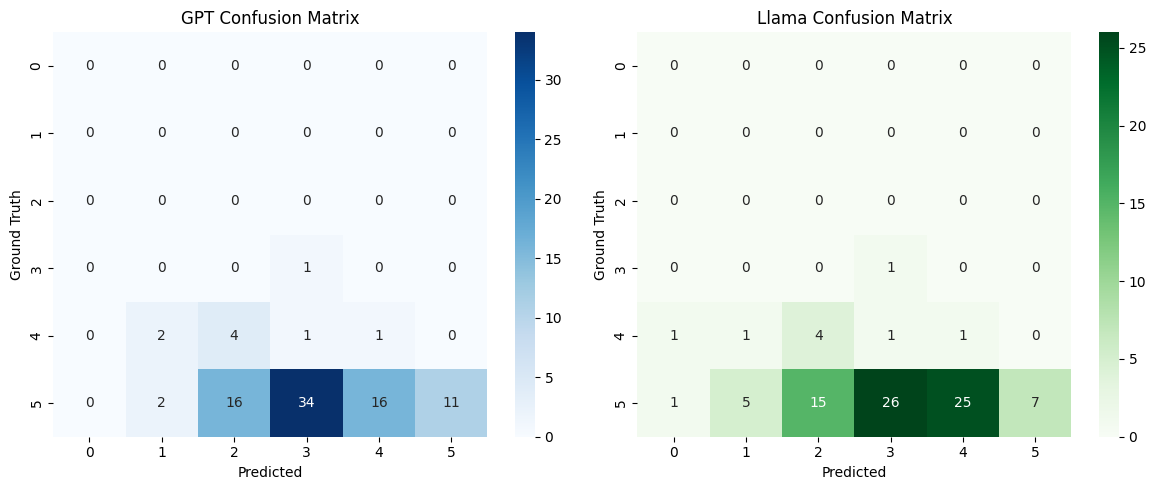

In [ ]:
plt.figure(figsize=(12, 5))

labels = [0, 1, 2, 3, 4, 5]

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_true, gpt, labels = labels), annot=True, fmt="d", cmap="Blues", xticklabels = labels, yticklabels = labels)
plt.title("GPT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_true, llama), annot=True, fmt="d", cmap="Greens")
plt.title("Llama Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")

plt.tight_layout()
plt.show()


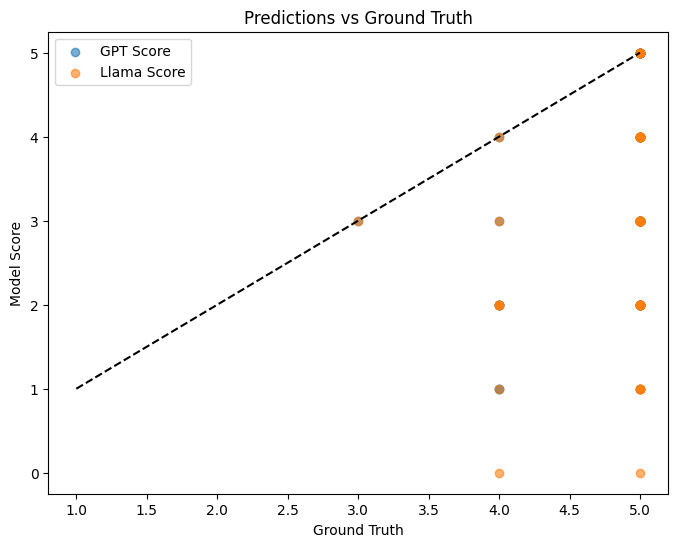

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_true, gpt, alpha=0.6, label="GPT Score")
plt.scatter(y_true, llama, alpha=0.6, label="Llama Score")
plt.plot([1,5], [1,5], 'k--')  # perfect match line
plt.xlabel("Ground Truth")
plt.ylabel("Model Score")
plt.title("Predictions vs Ground Truth")
plt.legend()
plt.show()


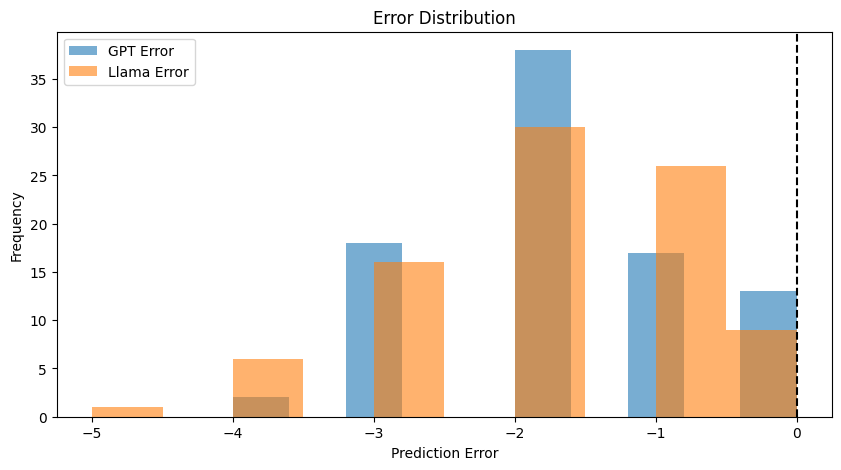

In [ ]:
results["GPT_Error"] = results["GPT_Score"] - results["Ground_Truth"]
results["Llama_Error"] = results["Llama_Score"] - results["Ground_Truth"]

plt.figure(figsize=(10,5))
plt.hist(results["GPT_Error"], bins=10, alpha=0.6, label="GPT Error")
plt.hist(results["Llama_Error"], bins=10, alpha=0.6, label="Llama Error")
plt.axvline(0, color='k', linestyle='--')
plt.title("Error Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [30]:
#Making dataframes for each elements individually

fullscore_df = pd.merge(scores, eval_df, left_on='FileName', right_on='FileName', how='inner')
#fullscore_df.columns

datascore = pd.DataFrame({'File_Name': fullscore_df['FileName'], 'GPT_Score': fullscore_df['Data_Score_x'], 'Llama_Score': fullscore_df['Data_Score_y'], 'Ground_Truth': fullscore_df['Data']})
#datascore.head()

aggregationscore = pd.DataFrame({'File_Name': fullscore_df['FileName'], 'GPT_Score': fullscore_df['Aggregation_Score_x'], 'Llama_Score': fullscore_df['Aggregation_Score_y'], 'Ground_Truth': fullscore_df['Aggregate']})
#aggregationscore.head()

graphscore = pd.DataFrame({'File_Name': fullscore_df['FileName'], 'GPT_Score': fullscore_df['Graph_Score_x'], 'Llama_Score': fullscore_df['Graph_Score_y'], 'Ground_Truth': fullscore_df['Graph']})
#graphscore.head()

advancedscore = pd.DataFrame({'File_Name': fullscore_df['FileName'], 'GPT_Score': fullscore_df['Adv_Func_Score_x'], 'Llama_Score': fullscore_df['Adv_Func_Score_y'], 'Ground_Truth': fullscore_df['Advanced']})
#advancedscore.head()

paragraphscore = pd.DataFrame({'File_Name': fullscore_df['FileName'], 'GPT_Score': fullscore_df['Paragraph_Score_x'], 'Llama_Score': fullscore_df['Paragraph_Score_y'], 'Ground_Truth': fullscore_df['Paragraph']})
#paragraphscore.head()

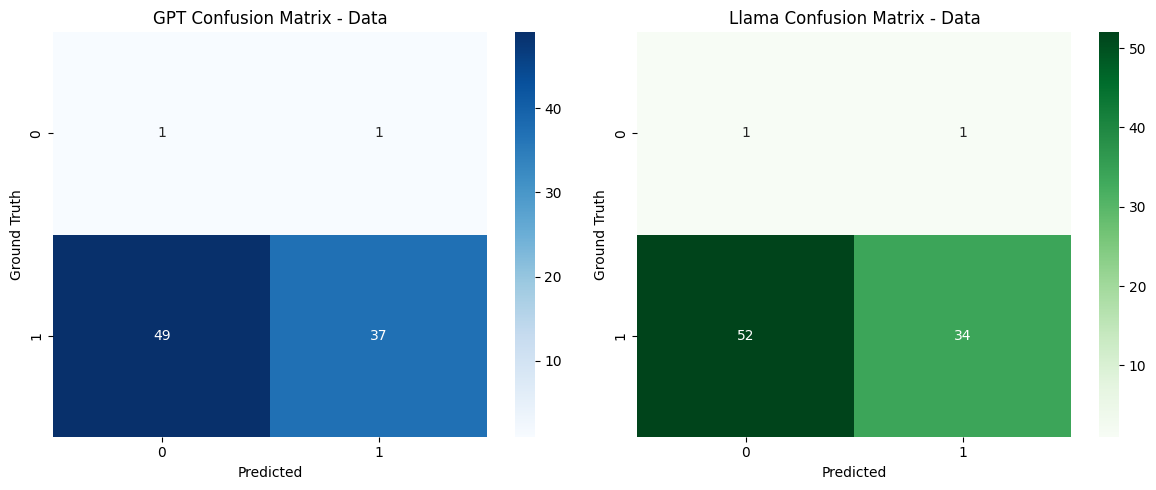

In [29]:
plt.figure(figsize=(12, 5))

labels = [0, 1]

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(datascore['Ground_Truth'], datascore['GPT_Score'], labels = labels), annot=True, fmt="d", cmap="Blues", xticklabels = labels, yticklabels = labels)
plt.title("GPT Confusion Matrix - Data")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(datascore['Ground_Truth'], datascore['Llama_Score'], labels = labels), annot=True, fmt="d", cmap="Greens", xticklabels = labels, yticklabels = labels)
plt.title("Llama Confusion Matrix - Data")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")

plt.tight_layout()
plt.show()

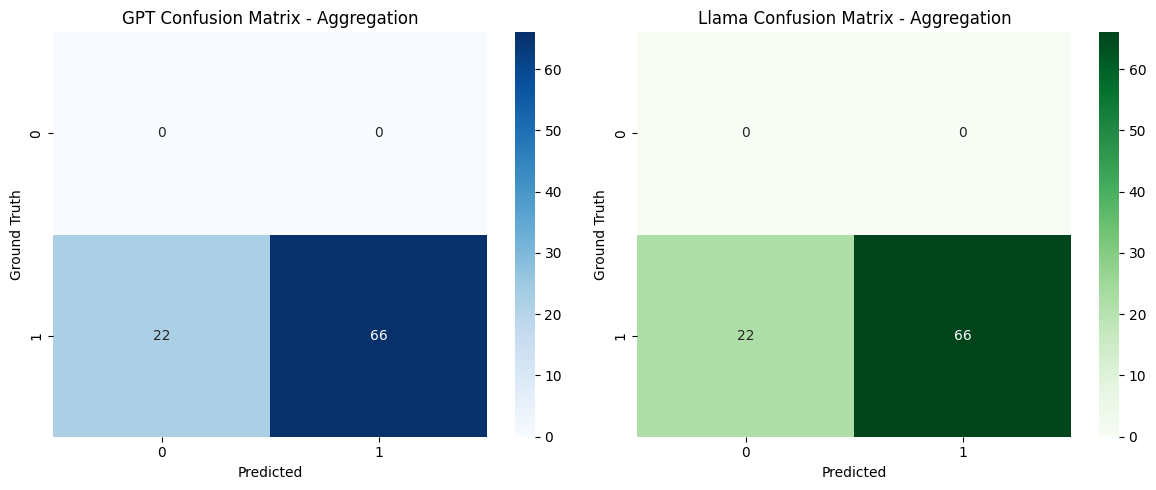

In [31]:
plt.figure(figsize=(12, 5))

labels = [0, 1]

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(aggregationscore['Ground_Truth'], aggregationscore['GPT_Score'], labels = labels), annot=True, fmt="d", cmap="Blues", xticklabels = labels, yticklabels = labels)
plt.title("GPT Confusion Matrix - Aggregation")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(aggregationscore['Ground_Truth'], aggregationscore['Llama_Score'], labels = labels), annot=True, fmt="d", cmap="Greens", xticklabels = labels, yticklabels = labels)
plt.title("Llama Confusion Matrix - Aggregation")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")

plt.tight_layout()
plt.show()

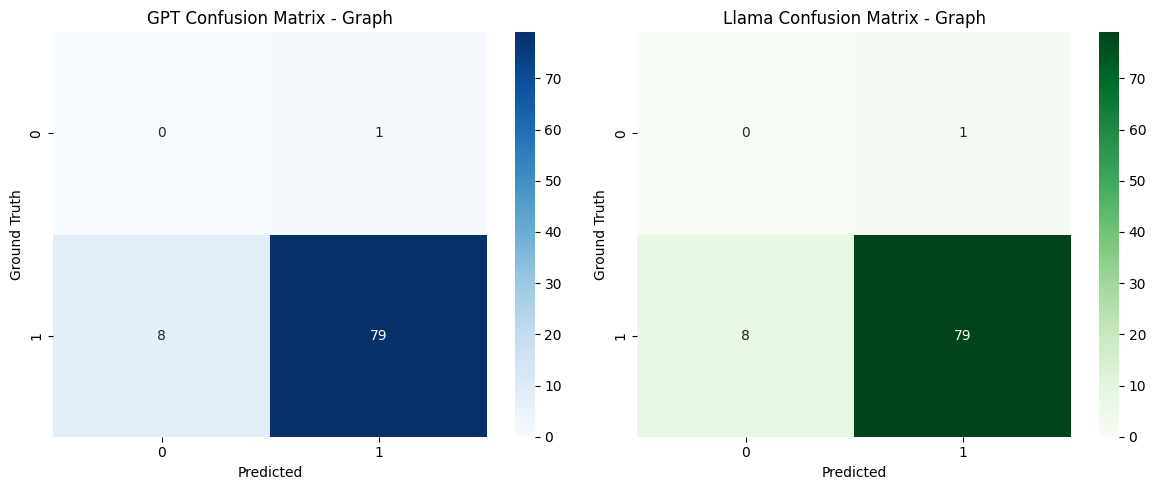

In [32]:
plt.figure(figsize=(12, 5))

labels = [0, 1]

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(graphscore['Ground_Truth'], graphscore['GPT_Score'], labels = labels), annot=True, fmt="d", cmap="Blues", xticklabels = labels, yticklabels = labels)
plt.title("GPT Confusion Matrix - Graph")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(graphscore['Ground_Truth'], graphscore['Llama_Score'], labels = labels), annot=True, fmt="d", cmap="Greens", xticklabels = labels, yticklabels = labels)
plt.title("Llama Confusion Matrix - Graph")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")

plt.tight_layout()
plt.show()

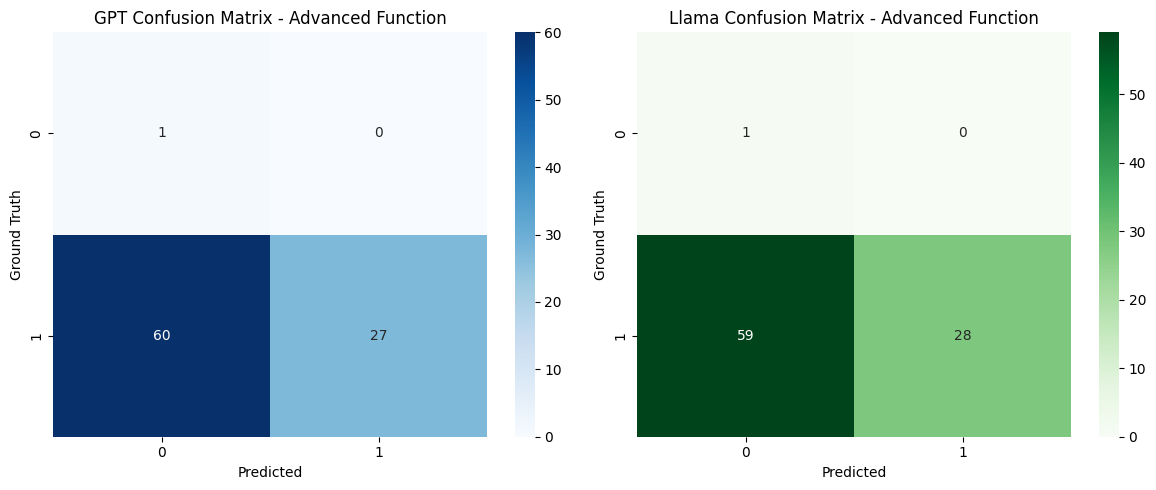

In [33]:
plt.figure(figsize=(12, 5))

labels = [0, 1]

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(advancedscore['Ground_Truth'], advancedscore['GPT_Score'], labels = labels), annot=True, fmt="d", cmap="Blues", xticklabels = labels, yticklabels = labels)
plt.title("GPT Confusion Matrix - Advanced Function")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(advancedscore['Ground_Truth'], advancedscore['Llama_Score'], labels = labels), annot=True, fmt="d", cmap="Greens", xticklabels = labels, yticklabels = labels)
plt.title("Llama Confusion Matrix - Advanced Function")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")

plt.tight_layout()
plt.show()

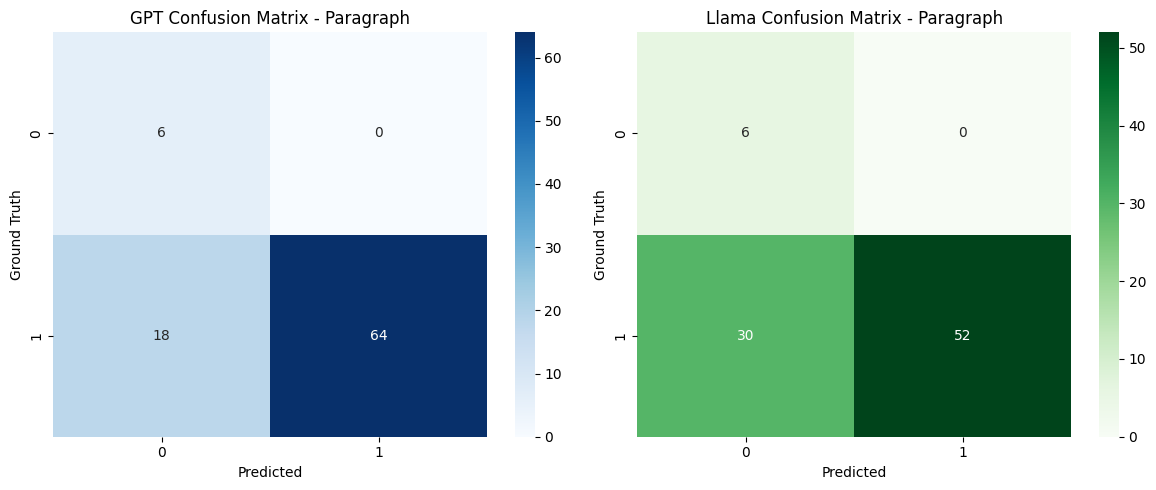

In [34]:
plt.figure(figsize=(12, 5))

labels = [0, 1]

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(paragraphscore['Ground_Truth'], paragraphscore['GPT_Score'], labels = labels), annot=True, fmt="d", cmap="Blues", xticklabels = labels, yticklabels = labels)
plt.title("GPT Confusion Matrix - Paragraph")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(paragraphscore['Ground_Truth'], paragraphscore['Llama_Score'], labels = labels), annot=True, fmt="d", cmap="Greens", xticklabels = labels, yticklabels = labels)
plt.title("Llama Confusion Matrix - Paragraph")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")

plt.tight_layout()
plt.show()

In [ ]:
subscores = [
    "Data_Score",
    "Aggregation_Score",
    "Graph_Score",
    "Adv_Func_Score",
    "Paragraph_Score"
]

In [ ]:
eval_df.columns

Index(['FileName', 'Semester', 'Score', 'Reason', 'Explanation', 'Filename_x',
       'Data_Score_x', 'Data_Comment_x', 'Aggregation_Score_x',
       'Agg_Comment_x', 'Graph_Score_x', 'Graph_Comment_x', 'Adv_Func_Score_x',
       'Adv_Func_Comment_x', 'Paragraph_Score_x', 'Paragraph_Comment_x',
       'Total_Score_x', 'Filename_y', 'Data_Score_y', 'Data_Comment_y',
       'Aggregation_Score_y', 'Agg_Comment_y', 'Graph_Score_y',
       'Graph_Comment_y', 'Adv_Func_Score_y', 'Adv_Func_Comment_y',
       'Paragraph_Score_y', 'Paragraph_Comment_y', 'Total_Score_y'],
      dtype='object')

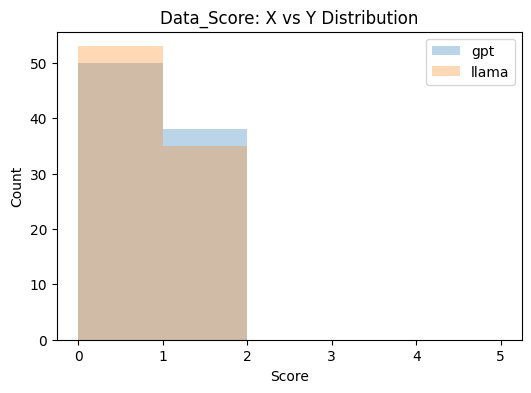

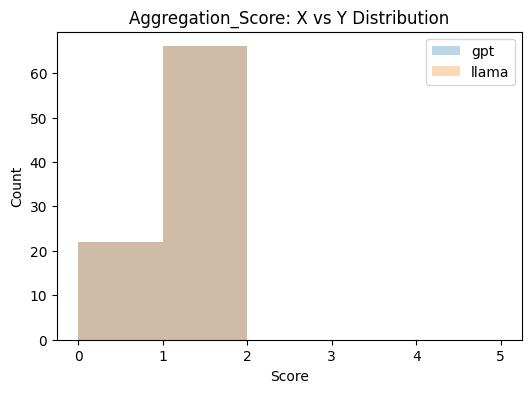

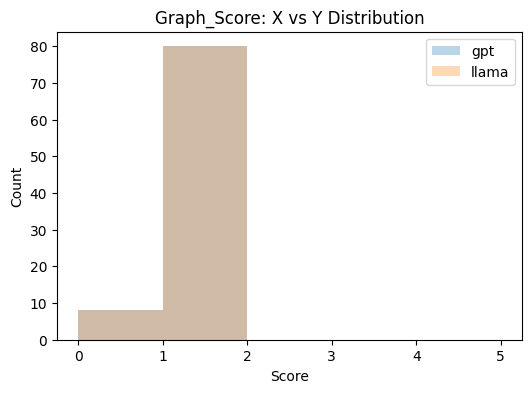

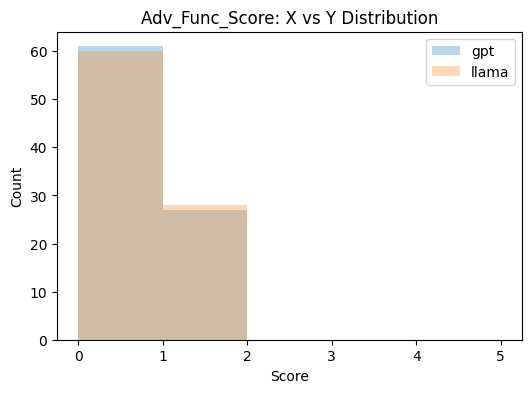

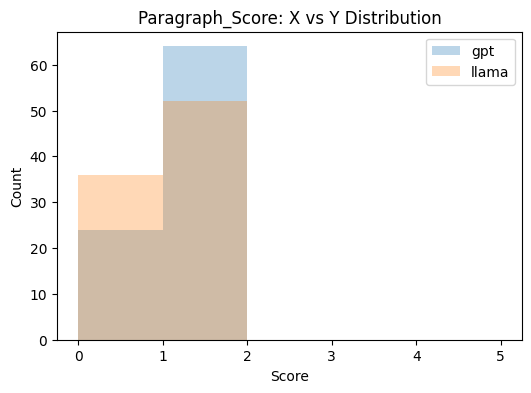

In [ ]:
for score in subscores:
    score_x = f"{score}_x"
    score_y = f"{score}_y"

    plt.figure(figsize=(6,4))

    plt.hist(eval_df[score_x], bins=[0,1,2,3,4,5], alpha=0.3, label='gpt')
    plt.hist(eval_df[score_y], bins=[0,1,2,3,4,5], alpha=0.3, label='llama')

    plt.title(f"{score}: X vs Y Distribution")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

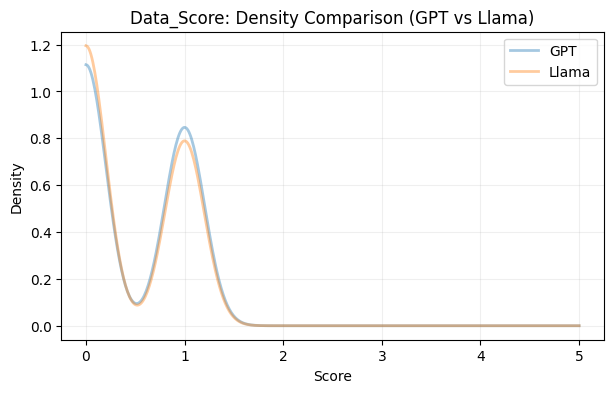

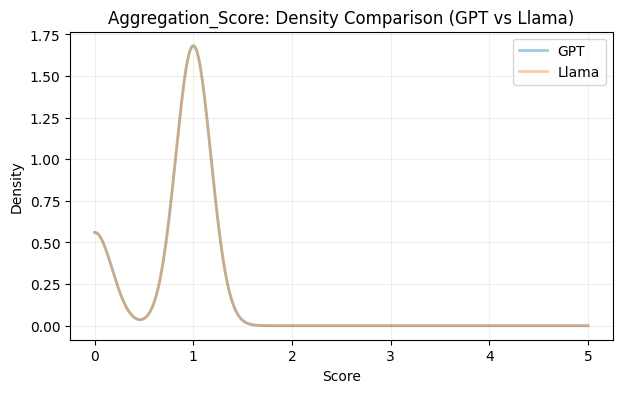

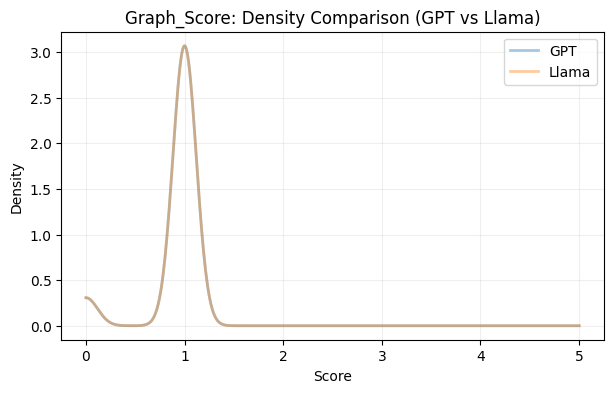

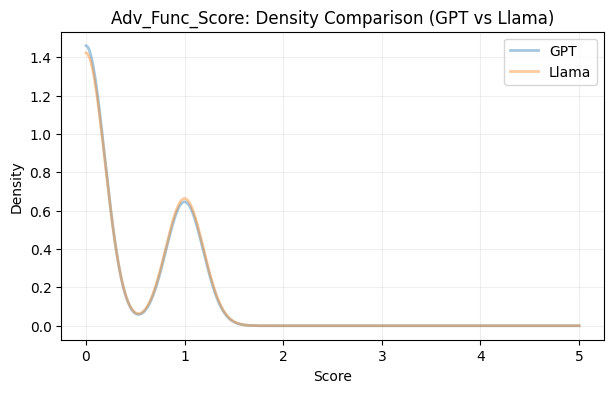

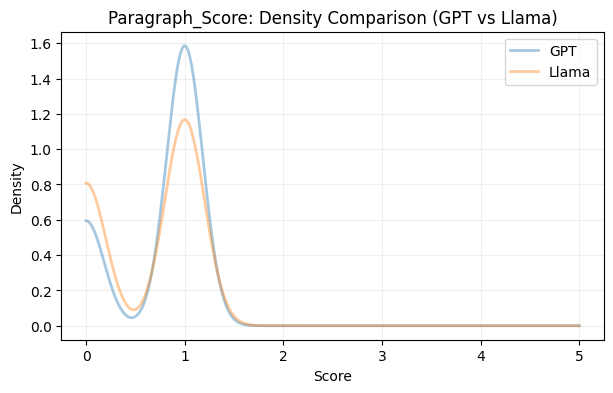

In [ ]:
from scipy.stats import gaussian_kde
import numpy as np


for score in subscores:
    score_x = f"{score}_x"   # GPT column
    score_y = f"{score}_y"   # Llama column

    # Extract values
    gpt_vals = eval_df[score_x].dropna()
    llama_vals = eval_df[score_y].dropna()

    # KDE curves
    gpt_kde = gaussian_kde(gpt_vals)
    llama_kde = gaussian_kde(llama_vals)

    # Score range (0–5)
    xs = np.linspace(0, 5, 500)

    plt.figure(figsize=(7,4))
    plt.plot(xs, gpt_kde(xs), label="GPT", linewidth=2, alpha=0.4)
    plt.plot(xs, llama_kde(xs), label="Llama", linewidth=2, alpha=0.4)

    plt.title(f"{score}: Density Comparison (GPT vs Llama)")
    plt.xlabel("Score")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()

/tmp/ipython-input-1231516854.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=["Ground Truth", "GPT", "Llama"])


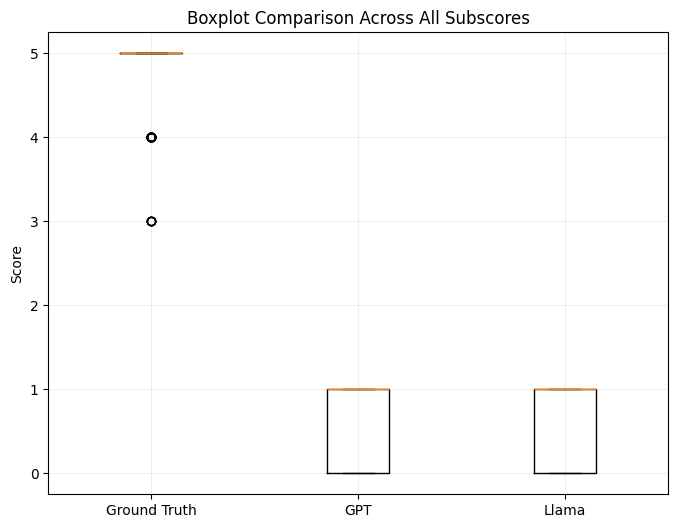

In [ ]:
# Combine all subscore columns into single series for each group
truth_values = pd.concat([eval_df["Score"]] * len(subscores), ignore_index=True)
gpt_values   = pd.concat([eval_df[f"{score}_x"] for score in subscores], ignore_index=True)
llama_values = pd.concat([eval_df[f"{score}_y"] for score in subscores], ignore_index=True)

# Create a list of series for boxplot
data_to_plot = [truth_values, gpt_values, llama_values]

plt.figure(figsize=(8,6))
plt.boxplot(data_to_plot, labels=["Ground Truth", "GPT", "Llama"])
plt.title("Boxplot Comparison Across All Subscores")
plt.ylabel("Score")
plt.grid(alpha=0.2)
plt.show()

,Score,Data_Score_x,Aggregation_Score_x,Graph_Score_x,Adv_Func_Score_x,Paragraph_Score_x,Total_Score_x,Data_Score_y,Aggregation_Score_y,Graph_Score_y,Adv_Func_Score_y,Paragraph_Score_y,Total_Score_y
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,4.886364,0.431818,0.750000,0.909091,0.306818,0.727273,3.125000,0.397727,0.750000,0.909091,0.318182,0.590909,3.034091
std,0.353369,0.498168,0.435494,0.289127,0.463816,0.447914,1.048398,0.492233,0.435494,0.289127,0.468440,0.494484,1.149201
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.750000,1.000000,0.000000,0.000000,2.000000,0.000000,0.750000,1.000000,0.000000,0.000000,2.000000
50%,5.000000,0.000000,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000,1.000000,1.000000,0.000000,1.000000,3.000000
75%,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000
max,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


## Conclusion
The benefit of an LLM for flexible grading is mainly in feature extraction. The data and metadata contained in even a single spreadsheet is too great to be included in a single API call (or open source LLM inference). And the majority of it is not significant. However, what is significant will be dependent on the assignment rubric. Since the point is to use LLM technology to create a flexible grader, this tool will need to be more holistic. It will need to be designed as an agent, prompting and interacting with the instructor as he/she creates the assignment requirements. Based on the requirements of the assignment, the agent will need to create the code to extract the needed features from a spreadsheet.

I see a initial agent architecture looking like the following:

```
+---------------------+
| Instructor          |
| (defines rubric,    |
|  provides examples) |
+----------+----------+
           |
           v
+--------------------------------------------+
| Instructor Interaction Layer (Chat/CLI)    |
| - Receives rubric descriptions             |
| - Shows clarifying questions to instructor |
+--------------------------------------------+
           |
           v
+-------------------------------------+
| Clarification Engine                |
| - Detects ambiguous rubric entries  |
| - Generates targeted questions      |
| - Updates structured rubric         |
+-------------------------------------+
           |
           v
+------------------------------------------------+
| Rubric Parser                                  |
| - Converts rubric into structured format:      |
|   {row_id, description, expected_type, weight} |
+------------------------------------------------+
           |
           v
+----------------------------------------------------------+
| Feature Extraction Code Generator                        |
| - Generates Python functions/scripts for each rubric row |
| - Uses templates for common feature types: numeric check,|
|   formula check, chart detection, text analysis          |
+----------------------------------------------------------+
           |
           v
+------------------------------------------------------------------+
| Spreadsheet Processor                                            |
| - Executes generated code on Excel                               |
| - Produces structured features per rubric row                    |
|   e.g. {row_count:32, has_chart:False, paragraph_word_count:4}   |
+------------------------------------------------------------------+
           |
           v
+-------------------------------------------------------+
| Grading Engine (LLM)                                  |
| - Inputs: extracted features + structured rubric info |
| - Maps features to scores and generates feedback      |
| - Rule-based scoring for objective features           |
+-------------------------------------------------------+
           |
           v
+--------------------------------------------------+
| Results Aggregator                               |
| - Aggregates row-level scores into overall score |
| - Produces detailed feedback report              |
| - Outputs: JSON                                  |
+--------------------------------------------------+
```